In [3]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight
import os
import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [4]:
from HNLprocessor.util import f_xsec
from HNLprocessor.util import f_v2

from HNLprocessor.util import f_xsec,f_xsec_tau
from HNLprocessor.util import f_v2,f_v2_tau
plt.style.use(hep.style.CMS) 

def loadLimits(f):
    T=uproot.open(f)['limit']
    return np.array(T['limit'].array())

def getf_xsec(f):
    mass = float(f.split("/")[-1].split("_")[3].replace("mHNL","").replace("p","."))      
    if "Dirac" in f:
        if "tau" in f:
            return lambda x: f_xsec_tau(mass)(x)*2                      
        else:
            return lambda x: f_xsec(mass)(x)*2
    else:
        if "tau" in f:
            return f_xsec_tau(mass)
        else:
            return f_xsec(mass)
    print("ERROR: cannot find xsec function for ",f)
    return

def getf_v2(f):
    mass = float(f.split("/")[-1].split("_")[3].replace("mHNL","").replace("p","."))      
    if "Dirac" in f:
        if "tau" in f:
            return lambda x: f_v2_tau(mass)(x)*2                      
        else:
            return lambda x: f_v2(mass)(x)*2
    else:
        if "tau" in f:
            return f_v2_tau(mass)
        else:
            return f_v2(mass)
    print("ERROR: cannot find v2 function for ",f)
    return


def loadLimitFiles(fpath,ctau_max=-1):
    arr =[]
    ctau = []
    for f in glob.glob(fpath):
        ct = f.split("/")[-1].split("_")[4].replace("pl","")
        mass = float(f.split("/")[-1].split("_")[3].replace("mHNL","").replace("p","."))  
              
        func_xsec = getf_xsec(f)
        xsec = func_xsec(float(ct))
        signalName = "_".join(f.split("/")[-1].split("_")[1:-1])   
        limit = loadLimits(f)
        norm=1
        if len(limit) !=6:
            print("Problem loading limit for ",signalName)
        else:
            if ctau_max>-1:
                if float(ct)<ctau_max:
                    arr.append(loadLimits(f)*xsec/norm)
                    ctau.append(float(ct))                            
            else:
                arr.append(loadLimits(f)*xsec/norm)
                ctau.append(float(ct))        
    arr = np.array(arr)
    ctau = np.array(ctau)
    return arr,ctau

from scipy.interpolate import Rbf,interp1d
from scipy import interpolate
import numpy as np
def interpolate1D(combineLimits,x,nBins=10,f="linear"):
    epsilon = 0.2
    smooth = 1
    newLimits = []
    if nBins<0:
        xi = np.sort(x)
    else:
        xi = np.logspace(np.log10(min(x)),np.log10(max(x)),nBins)    

    funcs=[]
    for i in range(6):
        y = combineLimits[:,i]
        if f=="linear":
            rbfi = interp1d(x, np.log(y),fill_value="extrapolate")
        else:
            rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)            
        yi = np.exp(rbfi(xi))
        newLimits.append(yi)
        funcs.append(rbfi)
    newLimits = np.array(newLimits).transpose()
    return newLimits, xi,funcs

def plotlimit(ax,CLs,poi_values,showBands = True, legend=True,color='black'
              ,mask=None,mask1sig=None,plotObs=False,maskObs=None):

    # index mapping:
    # 0 : -2 sigma
    # 1 : -1 sigma
    # 2 : expected
    # 3 : +1 sigma
    # 4 : +2 sigma
    # 5 : obs
    if type(mask)==type(np.array([])):
        poi_expected    = poi_values[mask]
        expected_CLs = CLs[mask,2]       
    else:
        poi_expected = poi_values
        expected_CLs = CLs[:,2]

    if maskObs is not None: 
        obs_CLs    = CLs[maskObs,5]         
        poi_obs    = poi_values[maskObs]
    else:
        poi_obs      = poi_values        
        obs_CLs      = CLs[:,5]                
        
    if plotObs:
        if legend:
            ax.plot(poi_obs, obs_CLs, color=color, label=r"expected CL$_S$")
        else:
            ax.plot(poi_obs, obs_CLs, color=color, label='_nolegend_')        
    if legend:
        ax.plot(poi_expected, expected_CLs, "--", color=color, label=r"expected CL$_S$")
    else:
        ax.plot(poi_expected, expected_CLs, "--", color=color, label='_nolegend_')        
        
        
    if showBands:
        # 1 and 2 sigma bands
        if legend:
            sigOnelabel = r"expected CL$_S$ $\pm 1\sigma$"
            sigTwolabel = r"expected CL$_S$ $\pm 2\sigma$"            
        else:
            sigOnelabel = '_nolegend_'
            sigTwolabel = '_nolegend_'
            
        ax.fill_between(
            poi_values,
            CLs[:, 1],
            CLs[:, 3],
            color="limegreen",
            label=sigOnelabel,
            where=mask1sig,
        )
        ax.fill_between(
            poi_values,
            CLs[:, 0],
            CLs[:, 4],
            color="yellow",
            label=sigTwolabel,
            zorder=0,  # draw beneath 1 sigma band
        )    
        
    return ax

def plotOneMass_fpath(fpath,showBand=True,ax=None,addTheory=True,color='black',plotObs=False):
    mass = float(fpath.split("/")[-1].split("_")[3].replace("mHNL","").replace("p","."))       

    isDirac = True if "Dirac" in fpath else False
    isTau   = True if "tau" in fpath else False
    if isTau:
        label   = r"$m_{HNL}^\tau=%.1fGeV$"%mass
        if "/ele" in fpath:
            channel = "Electron Channel\n"+label
            lumi    = "122"
        elif "/mu" in fpath:
            channel = "Muon Channel\n"+label
            lumi    = "120"
        else:
            channel = "Ele+Mu Channel\n"+label
            lumi    = "122"            
    else:
        if "ele" in fpath:
            label = r"$m_{HNL}^e=%.1fGeV$"%mass
            channel = "Electron Channel\n"+label            
            lumi    = "122"
        else:            
            label = r"$m_{HNL}^\mu=%.1fGeV$"%mass
            channel = "Muon Channel\n"+label            
            lumi    = "120"            
    if len(glob.glob(fpath))==0:
        print("Cannot find files with ",fpath)
        return
    arr,ctau = loadLimitFiles(fpath)
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)

    plt.style.use(hep.style.CMS) 

    if ax ==None:
        fig, ax = plt.subplots(figsize=(8,6))
    ax = plotlimit(ax,arr_i,ctau_i,showBand,color=color,plotObs=plotObs)
    if addTheory:
        if isDirac:
            if 'tau' in fpath:
                ax.plot(ctau_i,f_xsec_tau(mass)(ctau_i)*2,label="Theory")
            else:
                ax.plot(ctau_i,f_xsec(mass)(ctau_i)*2,label="Theory")                
        else:
            if 'tau' in fpath:
                ax.plot(ctau_i,f_xsec_tau(mass)(ctau_i),label="Theory")
            else:
                ax.plot(ctau_i,f_xsec(mass)(ctau_i),label="Theory")            

    ax.set_xlabel("ctau[mm]")
    ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
    ax.set_yscale("log")
    ax.set_xscale("log")
    if plotObs:
        ax.legend(["Observed","Expected","Theory"],title=channel,loc=1,fontsize="x-small",title_fontsize="x-small")
    else:
        ax.legend(["Expected","Theory"],title=channel,loc=1,fontsize="x-small")
        
    ytext = ax.get_ylim()[1]*0.8
    xtext  =ax.get_xlim()[0]*1.4
    ax.set_ylim(None,ax.get_ylim()[1]*4)

    if isDirac:
        ax.text(xtext,ytext,"Dirac")
    else:
        ax.text(xtext,ytext,"Majorana")        
    hep.cms.label(ax=ax,label="Preliminary",data=True,lumi=lumi)
    
    return ax

def get_masses(fpath,HNLtype="*"):
    ans =[p.split("/")[-1].split("_")[2].replace("mHNL","") for p in glob.glob(fpath+f'/*{HNLtype}*comb*.txt') if not "bkg" in p]
    return np.unique(ans)

def fill_zeros(y1,y2):
    y1_new=[]
    y2_new= []
    if (not np.any(y1))or (not np.any(y2)):
        print("Invalid ctau!")    
    for i,(iy1,iy2) in enumerate(zip(y1,y2)):
        #fill y1_new
        if iy1!=0: y1_new.append(iy1)
        elif y2[i]!=0: y1_new.append(y2[i])
        elif y1_new[i-1]!=0: y1_new.append((y1_new[i-1]+y2_new[i-1])/2)
        # fill y2_new
        if iy2!=0: y2_new.append(iy2)
        elif y1[i]!=0: y2_new.append(y1[i])
        elif y2_new[i-1]!=0: y2_new.append((y2_new[i-1]+y1_new[i-1])/2)      
    return np.array(y1_new),np.array(y2_new)

def get_ct_xing(fpath,init_ct):
    ## get limit and ctau from path
    arr,ctau = loadLimitFiles(fpath)
    ## get iterpolated limit and ctau from path    
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)
    func_xsec = getf_xsec(fpath)
    ct_xing = intersect(funcs,func_xsec,init_ct)
    return ct_xing

def get_ct_xing_up(fpath):
    arr,ctau = loadLimitFiles(fpath)
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)    
    func_xsec = getf_xsec(fpath)    
    ct_xing = intersect(funcs,func_xsec,int(min(ctau_i)))
    return ct_xing
def get_ct_xing_down(fpath):
    arr,ctau = loadLimitFiles(fpath)
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)    
    func_xsec = getf_xsec(fpath)        
    ct_xing = intersect(funcs,func_xsec,int(max(ctau_i)))
    return ct_xing

from scipy.optimize import fsolve
def intersect(funcs,xsec,x0):
    def eq(i):
        def eq_i(x):
            return np.exp(funcs[i](x))-xsec(x) 
        return eq_i
    if isinstance(x0,int):
        sol =[]
        for i in range(len(funcs)):
            root= fsolve(eq(i),x0,full_output=True)  
            ## fill only the converged solution
            if root[2]==1:
                sol.append(root[0])
            else:
                sol.append([0])
    else:
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    return np.array(sol)[:,0]

   

# Plot 1 mass point

(0.02076823884612687, 100.0)

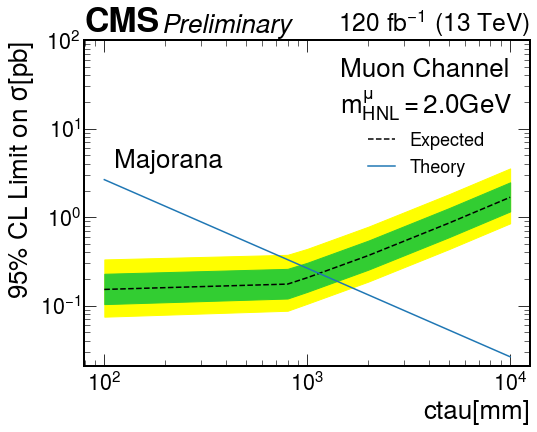

In [6]:
basedir="../limit/combine/HNL_datacards/muon_v20/"
fpath = f'{basedir}/higgsCombine_HNL_*muonType*_mHNL2p0_*_comb*.root'
ax = plotOneMass_fpath(fpath,plotObs=False)
ax.set_ylim(None,1e2)

# Plot all masspoints

In [7]:
def plotMajoranaCtau(savefig=False,plotObs=False):
    basedir_mu  = "../limit/combine/HNL_datacards/muon_v20"
    basedir_ele = "../limit/combine/HNL_datacards/ele_v14"  
    outdir = "./figures/result/unblind_Feb21/"
    for m in [1,2,3,4]:
        fpath = f'{basedir_mu}/higgsCombine_HNL_*muonType*_mHNL{m}p0_*_comb.Asy*.root'
        ax = plotOneMass_fpath(fpath,plotObs=plotObs) 
        if m==1:ax.set_ylim(None,1e4)
        if m==2:ax.set_ylim(None,1e2)            
        if savefig:
            plt.tight_layout()
            plt.savefig(f'{outdir}AsymLimit_muon_majorana_{m}GeV.pdf')

    for m in [1,2,3,4]:
        fpath = f'{basedir_ele}/higgsCombine_HNL_*electronType*_mHNL{m}p0_*_comb*.root'
        ax = plotOneMass_fpath(fpath,plotObs=plotObs) 
        if m==1:ax.set_ylim(None,1e4)   
        if m==2:ax.set_ylim(None,1e2)              
        if savefig:
            plt.tight_layout()
            plt.savefig(f'{outdir}AsymLimit_ele_majorana_{m}GeV.pdf')
    m=2
    basedir_tau ="../limit/combine/HNL_datacards/tau_v4/"
    for subdir,name in zip(
                        ["ele/","mu/",""],
                        ["ele","mu","comb"]):
        fpath =  f'{basedir_tau}{subdir}higgsCombine_HNL_*tauTypeleptonFilter*_mHNL{m}p0_*_comb*.root'  
        ax = plotOneMass_fpath(fpath,plotObs=plotObs)
        if savefig:
            plt.tight_layout()       
            plt.savefig(f'{outdir}AsymLimit_tau_{name}_majorana_{m}GeV.pdf')
    return

def plotDiracCtau(savefig=False,plotObs=False):
    basedir_mu = "../limit/combine/HNL_datacards/muon_v20"
    basedir_ele = "../limit/combine/HNL_datacards/ele_v14"    
    outdir = "./figures/result/unblind_Feb21/"

    for m in [1,2,3,4]:        
        fpath = f'{basedir_mu}/higgsCombine_HNL_*muonDiracType*_mHNL{m}p0_*_comb*.root'
        ax = plotOneMass_fpath(fpath,plotObs=plotObs)
        if m==1:ax.set_ylim(None,1e4)
        if m==2:ax.set_ylim(None,1e2)          
        if savefig:
            plt.tight_layout()
            plt.savefig(f'{outdir}AsymLimit_muon_dirac_{m}GeV.pdf')        
    for m in [1,2,3,4]:            
        fpath = f'{basedir_ele}/higgsCombine_HNL_*electronDiracType*_mHNL{m}p0_*comb*.root'      
        ax = plotOneMass_fpath(fpath,plotObs=plotObs) 
        if m==1:ax.set_ylim(None,1e4)
        if m==2:ax.set_ylim(None,1e2)          
        if savefig:
            plt.tight_layout()
            plt.savefig(f'{outdir}AsymLimit_ele_dirac_{m}GeV.pdf')        
    m=2
    basedir_tau ="../limit/combine/HNL_datacards/tau_v4/"
    for subdir,name in zip(
                        ["ele/","mu/",""],
                        ["ele","mu","comb"]):
        fpath =  f'{basedir_tau}{subdir}higgsCombine_HNL_*tauDiracTypeleptonFilter*_mHNL{m}p0_*_comb*.root'  
        ax = plotOneMass_fpath(fpath,plotObs=plotObs)
        if savefig:
            plt.tight_layout()       
            plt.savefig(f'{outdir}AsymLimit_tau_{name}_dirac_{m}GeV.pdf')             


# V^2 vs M limits

In [8]:
def get_limits(basedir,HNLtype,masses_up,masses_down,debug=False):
    masses_str = get_masses(basedir,HNLtype)
    fpaths = []
    print("Available masses = ",masses_str)
    for mass_str in masses_str:
        fpaths.append( f'{basedir}higgsCombine_HNL_*{HNLtype}*_mHNL{mass_str}_pl*_comb.Asym*.root') 
    ct_up,limits_up,m_up =[], [],[]
    ct_down,limits_down,m_down =[], [],[]   

    for fpath in fpaths:
        print(fpath)
        mass = float(fpath.split("/")[-1].split("_")[3].replace("mHNL","").replace("p","."))
        func_v2 = getf_v2(fpath)        
        if mass in masses_up:
            ct_xing_up = get_ct_xing_up(fpath)
            if debug:
                print(mass,ct_xing_up)              
            m_up.append(mass)              
        if mass in masses_down:
            ct_xing_down = get_ct_xing_down(fpath)
            if debug:
                print(mass,ct_xing_down)            
            m_down.append(mass)
        ## Fill the invalid limit points
        if mass in masses_up and mass in masses_down:
            y_up_new, y_down_new = fill_zeros(ct_xing_up,ct_xing_down)            
            ct_up.append(y_up_new)
            ct_down.append(y_down_new)            
            limits_up.append(func_v2(y_up_new))
            limits_down.append(func_v2(y_down_new))
            if debug:
                print(mass,y_up_new)     
                print(mass,y_down_new)
        elif mass in masses_up:
            if debug: print(mass,ct_xing_up)                        
            ct_up.append(ct_xing_up)                
            limits_up.append(func_v2(ct_xing_up))
        elif mass in masses_down:
            if debug: print(mass,ct_xing_down)            
            ct_down.append(ct_xing_down)
            limits_down.append(func_v2(ct_xing_down))       
    result= {
        'm_up': np.array(m_up),
        'limit_up':np.array(limits_up),
        'm_down': np.array(m_down),
        'limit_down':np.array(limits_down),        
        'ct_up':np.array(ct_up),
        'ct_down':np.array(ct_down),        
    }
    return result 

# Electron limits

In [9]:
m_down = [1,2,2.5,2.8,3.0,3.1,3.2,3.3,3.4,3.5]
m_up   =    [ 2.8,3.0,3.1,3.2,3.3,3.4,3.5]
result = get_limits("../limit/combine/HNL_datacards/ele_v14/","electronType",m_up,m_down,False)

result['limit_up'][-1][4:5] = result['limit_up'][-1][2:3]
result['limit_down'][-1][4:5] = result['limit_down'][-1][2:3]

result['limit_up'][-2][4:5] = result['limit_up'][-2][2:3]
result['limit_down'][-2][4:5] = result['limit_down'][-2][2:3]

Available masses =  ['1p0' '2p0' '2p5' '2p8' '3p0' '3p1' '3p2' '3p3' '3p4' '3p5' '4p0']
../limit/combine/HNL_datacards/ele_v14/higgsCombine_HNL_*electronType*_mHNL1p0_pl*_comb.Asym*.root
../limit/combine/HNL_datacards/ele_v14/higgsCombine_HNL_*electronType*_mHNL2p0_pl*_comb.Asym*.root
../limit/combine/HNL_datacards/ele_v14/higgsCombine_HNL_*electronType*_mHNL2p5_pl*_comb.Asym*.root
../limit/combine/HNL_datacards/ele_v14/higgsCombine_HNL_*electronType*_mHNL2p8_pl*_comb.Asym*.root
../limit/combine/HNL_datacards/ele_v14/higgsCombine_HNL_*electronType*_mHNL3p0_pl*_comb.Asym*.root
../limit/combine/HNL_datacards/ele_v14/higgsCombine_HNL_*electronType*_mHNL3p1_pl*_comb.Asym*.root
../limit/combine/HNL_datacards/ele_v14/higgsCombine_HNL_*electronType*_mHNL3p2_pl*_comb.Asym*.root
../limit/combine/HNL_datacards/ele_v14/higgsCombine_HNL_*electronType*_mHNL3p3_pl*_comb.Asym*.root
../limit/combine/HNL_datacards/ele_v14/higgsCombine_HNL_*electronType*_mHNL3p4_pl*_comb.Asym*.root
../limit/combine/HNL_

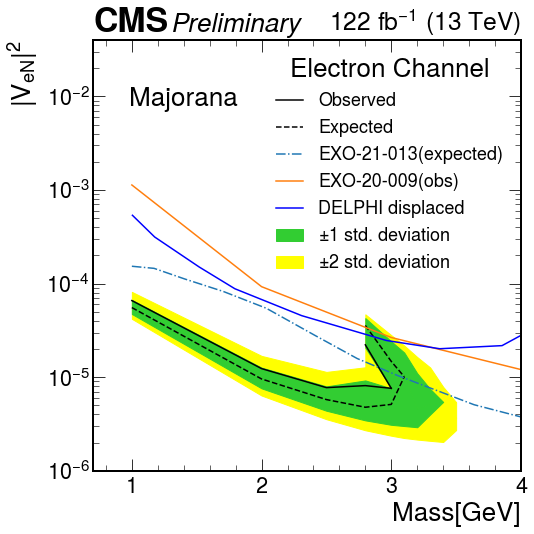

In [11]:
plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,8))

plotObs=False
ax = plotlimit(ax,result['limit_down'],result['m_down'],True,True,"black"
                 ,result['m_down']<3.2,result['m_down']<=3.4,True,maskObs=result['m_down']<=3.0)
ax = plotlimit(ax,result['limit_up']  ,result['m_up']  ,True,False,'black'
                 ,result['m_up']<3.2 ,result['m_up']<=3.4,True,maskObs=result['m_up']<=3.0)

EXO = np.genfromtxt("../limit/otherHNLlimits/EXO-21-013_ele_majorana.csv",delimiter=",")
EXO_20_009 = np.genfromtxt("../limit/otherHNLlimits/EXO-20-009-Majorana-ele-obs_v2.csv",delimiter=",")
Delphi = np.genfromtxt("../limit/otherHNLlimits/Delphi-displaced-majorana-ele.csv",delimiter=",")

ax.plot(EXO[:,0],EXO[:,1],label="EXO-21-013(expected)",ls='-.')
ax.plot(EXO_20_009[:,0],EXO_20_009[:,1],label="EXO-20-009(obs)")
ax.plot(Delphi[:,0],Delphi[:,1],label="DELPHI displaced",color='blue')

ax.legend(["Observed",
           "Expected",
           "EXO-21-013(expected)",
           "EXO-20-009(obs)",           
           "DELPHI displaced",
           r"$\pm$1 std. deviation",
           r"$\pm$2 std. deviation"],
          loc=1,fontsize='x-small',
          title="Electron Channel")
ax.set_yscale("log")
ax.set_ylabel(r"$|V_{e N}|^2$")
ax.set_xlabel("Mass[GeV]")
ax.set_xlim(0.7,4)
ax.set_ylim(1e-6,1e-2)
ytext = ax.get_ylim()[1]*0.8
xtext  =ax.get_xlim()[0]*1.4
ax.set_ylim(None,ax.get_ylim()[1]*4)
ax.text(xtext,ytext,"Majorana") 
hep.cms.label(ax=ax,label="Preliminary",data=True,lumi="122")
plt.tight_layout()
# fig.savefig("./figures/result/unblind_Feb21/AsymLimit_VeN_ele_majorana.pdf")